## Data Exploration

This notebook was developed on Ubuntu 20.04, python 3.8.10. It should also work on colab.

In [19]:
%pip install pandas openpyxl

Note: you may need to restart the kernel to use updated packages.


### Data Preparation (converting to timestamps)

In [24]:
import pandas as pd
import networkx as nx
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder

# Function to convert semester string to datetime object
def convert_semester_to_date(semester_str):
    months = {"Spring": 1, "Summer": 6, "SummerOne" : 5, "SummerTwo" : 7, "Fall": 9}
    season = ""

    if pd.isnull(semester_str):
        return None

    split_str = semester_str.split()
    year = split_str[-1]
    season_words = split_str[0:len(split_str)-1] #Because of summer sessions, EG: "Summer One 2022"
    for i in season_words:
        season += i
    
    return datetime(int(year), months[season], 1)

#Merge trans columns into pass columns
def merge_trans_classes(df):
    pass_classes = [col for col in df.columns if "Pass" in col]
    trans_classes = [col for col in df.columns if "Tran" in col]

    #Combine the trans into the pass
    for t in trans_classes:
        class_name = t.split("_")[0]
        for p in pass_classes:
            if class_name in p:
                df[p] = df[p].combine_first(df[t])

    #Drop the trans cols
    for t in trans_classes:
        df = df.drop(t,axis=1)
    
    return df

def merge_new_classes(df):
    df["CSCI220_Pass_Sem"] = df["CSCI220_Pass_Sem"].combine_first(df["CSCI262_Pass_Sem"])
    df["CSCI210_Pass_Sem"] = df["CSCI210_Pass_Sem"].combine_first(df["CSCI261_Pass_C_Sem"])
    return df



# Load the Excel file
df = pd.read_excel('/home/lithium/Network-Science-Project/CS Course Enrollment Data 030824.xlsx')
df = merge_trans_classes(df)
df = merge_new_classes(df)

# Get all the semester columns.
semester_cols = df.columns[3:-2]

for col in semester_cols:
    df[col] = df[col].apply(convert_semester_to_date)

df

FileNotFoundError: [Errno 2] No such file or directory: '/home/lithium/Network-Science-Project/CS Course Enrollment Data 030824.xlsx'

### Data Analysis

This section of the code is basically just looking at passes for a class over a specific time.

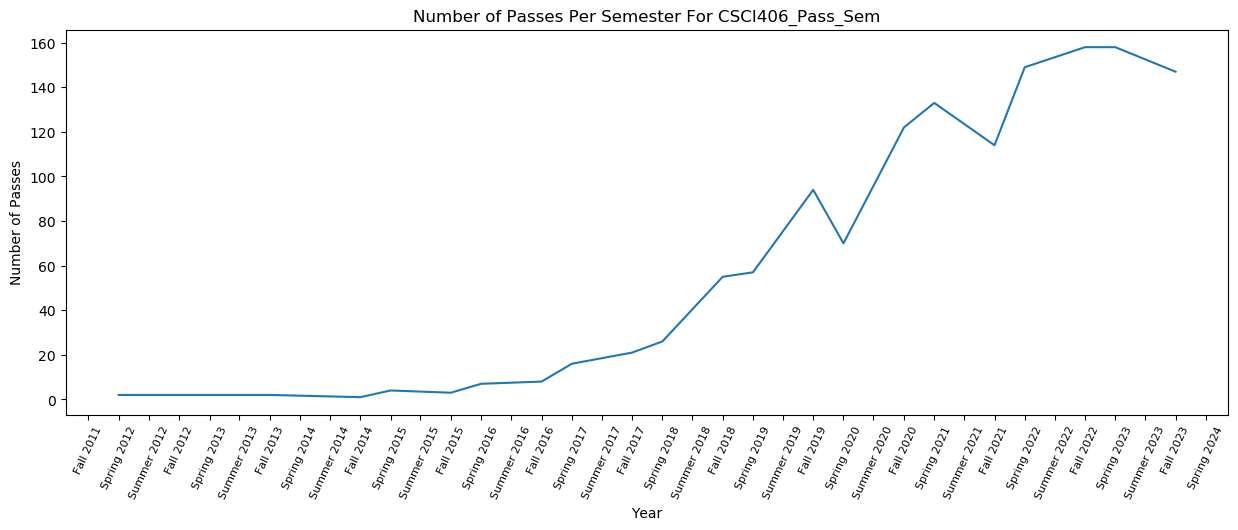

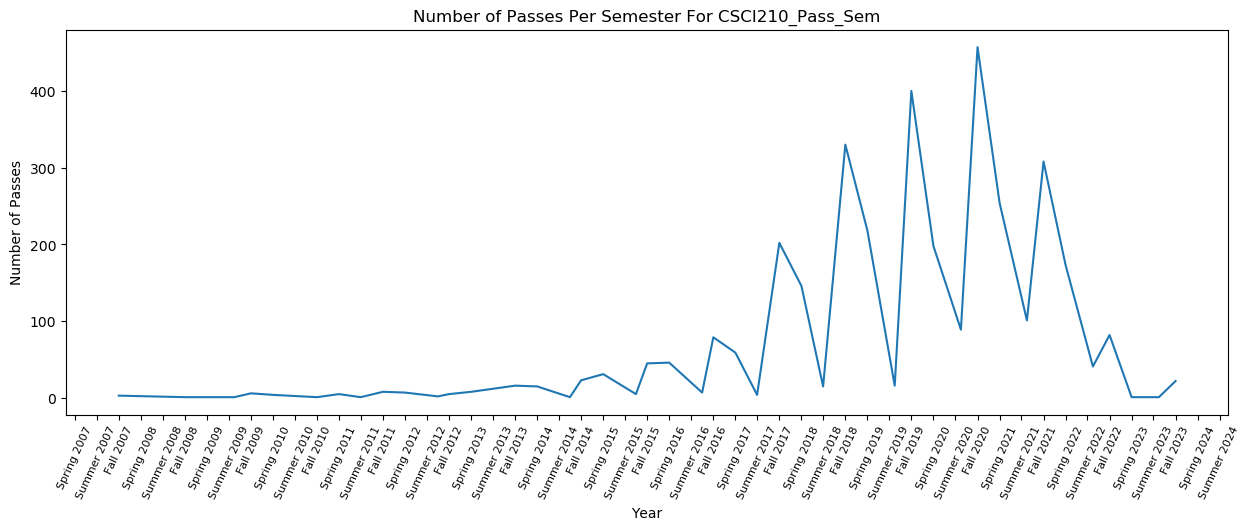

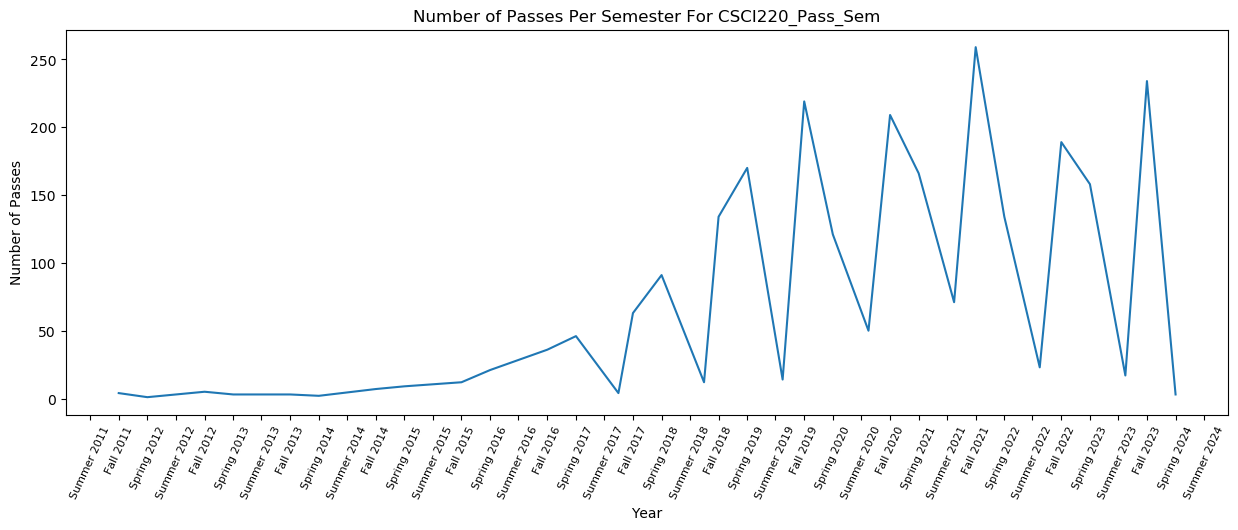

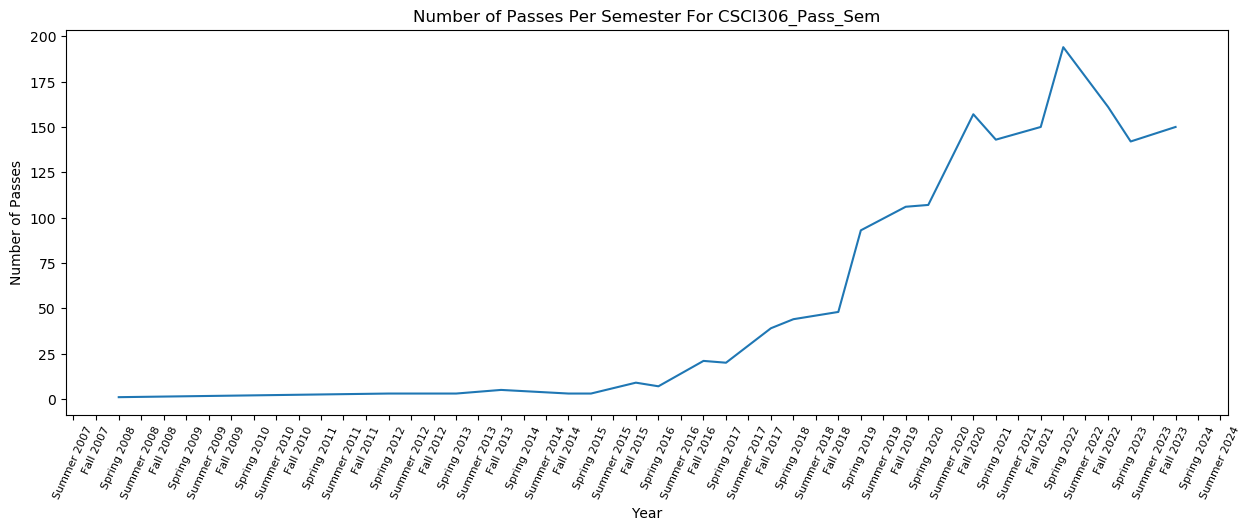

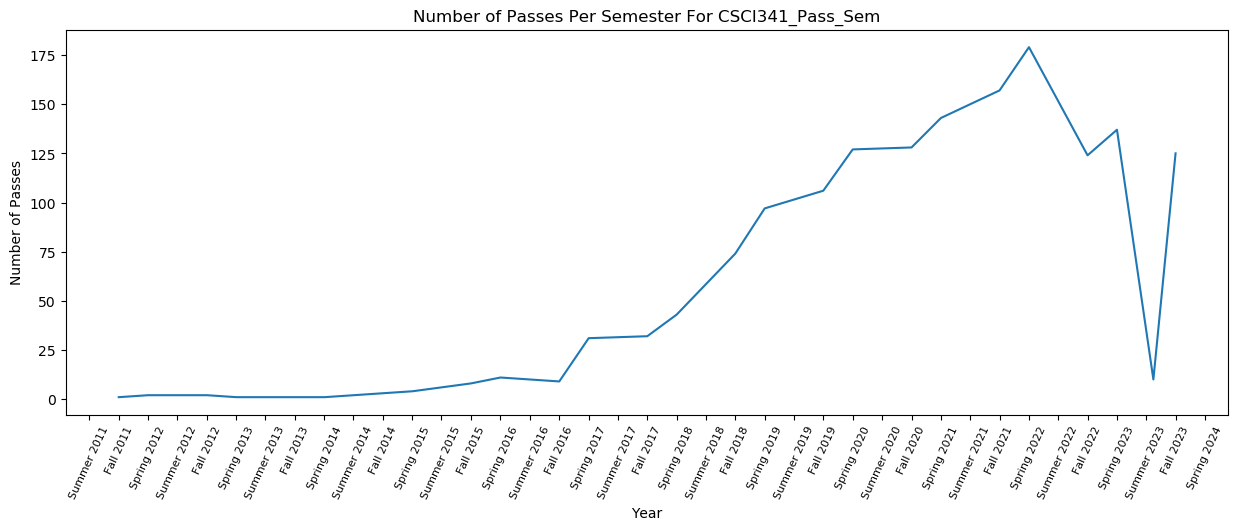

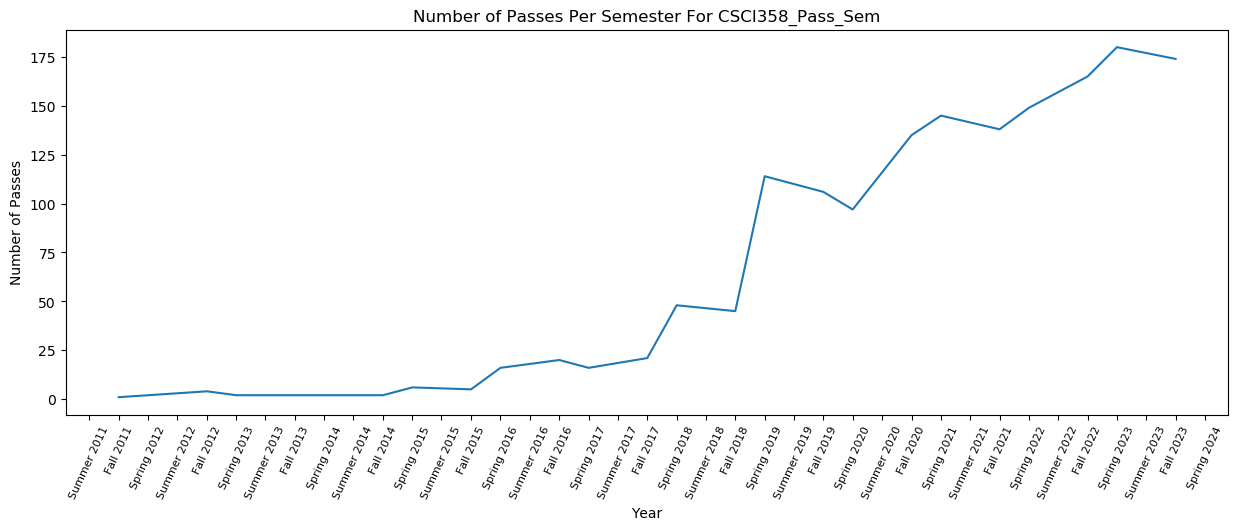

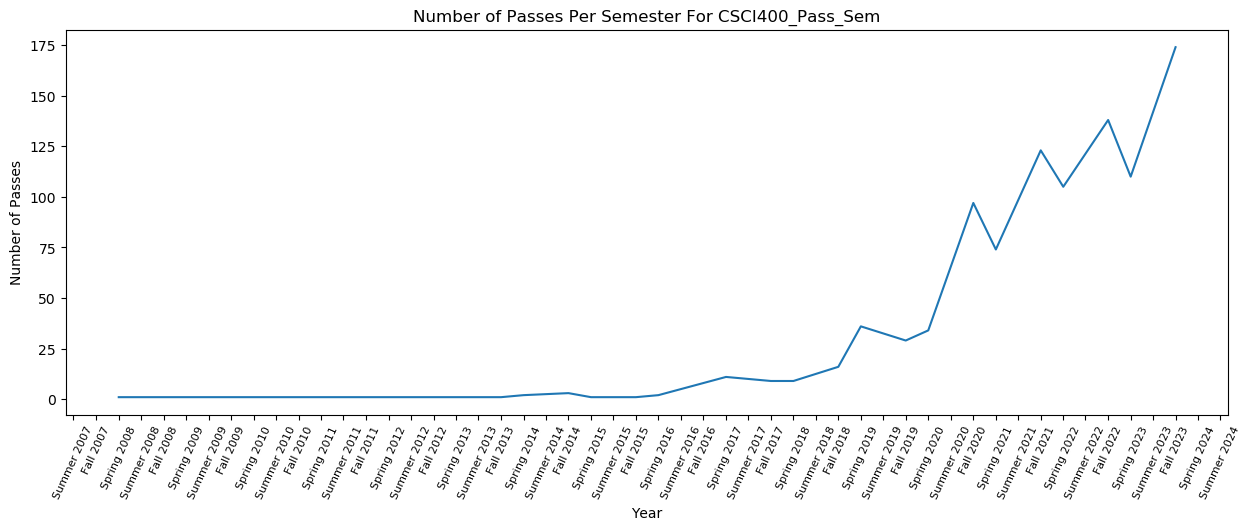

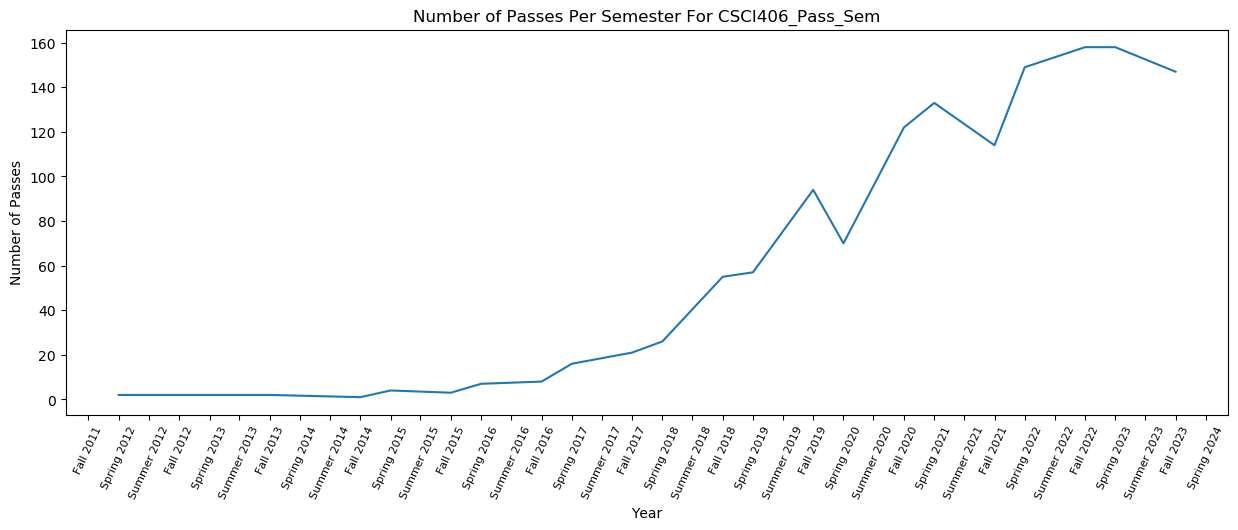

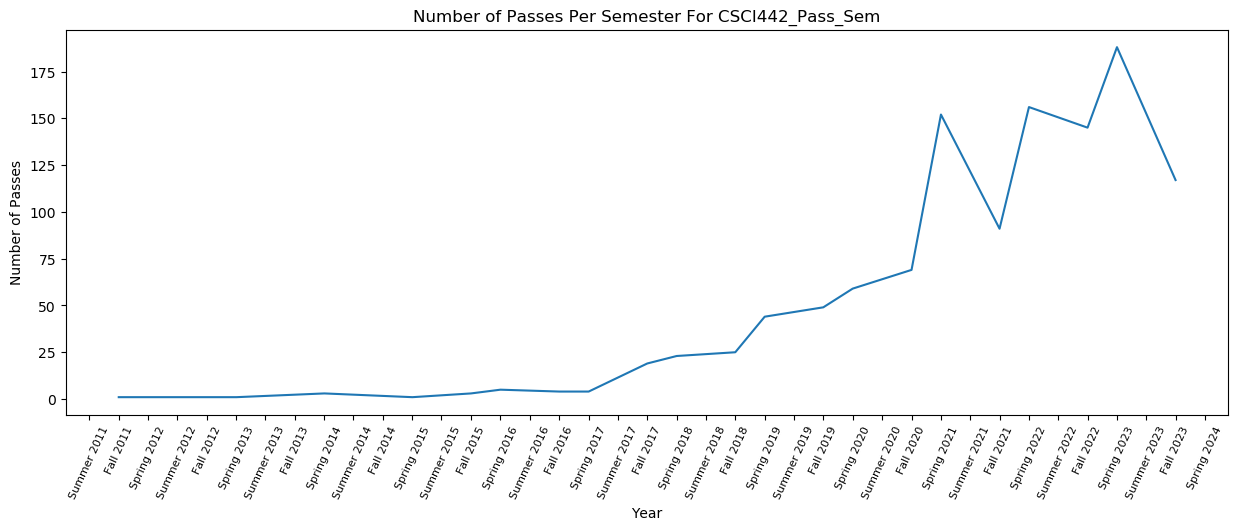

In [22]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib
import pylab as pl


def get_class_data(class_name = 'CSCI406_Pass_Sem'):
    combined_passes = df[class_name].dropna()
    combined_passes = combined_passes.value_counts().sort_index()

    return combined_passes

#Plot a single class.
def plot_class(class_name):
    fig, axis = plt.subplots(figsize=(15,5))  
    # fig.tight_layout(pad=10)
    class_data = get_class_data(class_name)
    ax_obj = axis


    def custom_formatter(x, pos):
        date = pl.num2date(x)
        month = date.month
        if month < 5:
            semester = "Spring"
        elif month >= 5 and month < 8:
            semester = "Summer"
        elif month >= 8 :
            semester = "Fall"

        
        return f"{semester} {date.year}"

    ax_obj.xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth=(1,5,9)))
    ax_obj.xaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
    ax_obj.tick_params(axis='x', labelsize=8)

    # Plotting
    ax_obj.plot(class_data)
    ax_obj.set_title(f'Number of Passes Per Semester For {class_name}')
    ax_obj.set_xlabel('Year')
    ax_obj.set_ylabel('Number of Passes')
    ax_obj.tick_params(axis='x', rotation=65)

    plt.show()




for col in ["CSCI406_Pass_Sem", "CSCI210_Pass_Sem","CSCI220_Pass_Sem","CSCI306_Pass_Sem","CSCI341_Pass_Sem","CSCI358_Pass_Sem", "CSCI400_Pass_Sem","CSCI406_Pass_Sem","CSCI442_Pass_Sem"]:
    plot_class(col)

Because Freshman for Fall 2024 are not going to be registered for their classes until late this summer, we want to excude them from our predictions. 200 is probably the only class with Freshman in it, as there is no ap credit for 200 unlike for 261. I will augment it with 261 data. 

In [1]:
import re
import pandas as pd
columns = ["ADMIT_ACADEMIC_PERIOD_DESC", "CSCI261_Pass_C_Sem", "CSCI200_Pass_C_Sem"]
raw_data = pd.read_excel('CS Course Enrollment Data 030824.xlsx')
new_df = raw_data.loc[:, columns] # filter for only classes we want


# Create dictionaries of counts of students in each class for each semester listed
course_data = {}
# Iterate over each column in the DataFrame
for column in new_df.columns:
    if column == "ADMIT_ACADEMIC_PERIOD_DESC": # ignore this col since it's not a class
        continue
    # Get counts of unique values in the column
    value_counts = new_df[column].value_counts()
    
    # Convert value_counts Series to dictionary
    counts_dict = value_counts.to_dict()
    
    # Store the dictionary of counts for the column
    course_data[column] = counts_dict


for course, counts_dict in course_data.items():
    spring = r'^Spring'
    summer = r'Summer'
    counts_dict = {key: value for key, value in counts_dict.items() if not re.match(spring, key)}
    counts_dict = {key: value for key, value in counts_dict.items() if not re.match(summer, key)}
    counts_dict = dict(sorted(counts_dict.items()))
    course_data[course] = counts_dict

for course, counts_dict in course_data.items():
    print(f"Counts for {course}:")
    print(counts_dict)
    print()

Counts for CSCI261_Pass_C_Sem:
{'Fall 2007': 2, 'Fall 2008': 1, 'Fall 2009': 4, 'Fall 2011': 4, 'Fall 2012': 5, 'Fall 2013': 8, 'Fall 2014': 18, 'Fall 2015': 26, 'Fall 2016': 56, 'Fall 2017': 112, 'Fall 2018': 236, 'Fall 2019': 255, 'Fall 2020': 289, 'Fall 2021': 173, 'Fall 2022': 15}

Counts for CSCI200_Pass_C_Sem:
{'Fall 2022': 191, 'Fall 2023': 302}



In [2]:
fresh_dict = {}
for course, counts_dict in course_data.items():
    fresh_count_dict = {}
    for key, val in counts_dict.items():
        # find the number of rows in the df where ADMIT_ACADEMIC_PERIOD_DESC = key AND course = KEY
        matches = ((new_df["ADMIT_ACADEMIC_PERIOD_DESC"] == key) & (new_df[course] == key)).sum()
        fresh_count_dict.update({key:matches})
    fresh_dict.update({course:fresh_count_dict})
    
for course, counts_dict in fresh_dict.items():
    print(f"Counts for {course}:")
    print(counts_dict)
    print()

for course, counts_dict in course_data.items():
    print(f"Counts for {course}:")
    print(counts_dict)
    print()

Counts for CSCI261_Pass_C_Sem:
{'Fall 2007': 0, 'Fall 2008': 0, 'Fall 2009': 0, 'Fall 2011': 0, 'Fall 2012': 0, 'Fall 2013': 0, 'Fall 2014': 0, 'Fall 2015': 0, 'Fall 2016': 0, 'Fall 2017': 60, 'Fall 2018': 106, 'Fall 2019': 119, 'Fall 2020': 142, 'Fall 2021': 67, 'Fall 2022': 11}

Counts for CSCI200_Pass_C_Sem:
{'Fall 2022': 71, 'Fall 2023': 131}

Counts for CSCI261_Pass_C_Sem:
{'Fall 2007': 2, 'Fall 2008': 1, 'Fall 2009': 4, 'Fall 2011': 4, 'Fall 2012': 5, 'Fall 2013': 8, 'Fall 2014': 18, 'Fall 2015': 26, 'Fall 2016': 56, 'Fall 2017': 112, 'Fall 2018': 236, 'Fall 2019': 255, 'Fall 2020': 289, 'Fall 2021': 173, 'Fall 2022': 15}

Counts for CSCI200_Pass_C_Sem:
{'Fall 2022': 191, 'Fall 2023': 302}



In [3]:
# squash together
course_data.get("CSCI261_Pass_C_Sem").update(course_data.get("CSCI200_Pass_C_Sem"))
# delete unnecessary columns
del course_data["CSCI200_Pass_C_Sem"]
# rename to 200 
course_data["CSCI200_Pass_C_Sem"] = course_data.pop("CSCI261_Pass_C_Sem")

In [4]:
fresh_dict.get("CSCI261_Pass_C_Sem").update(fresh_dict.get("CSCI200_Pass_C_Sem"))
# delete unnecessary columns
del fresh_dict["CSCI200_Pass_C_Sem"]
# rename to 200 
fresh_dict["CSCI200_Pass_C_Sem"] = fresh_dict.pop("CSCI261_Pass_C_Sem")


In [10]:
# get lists of everything 
all_students = list(course_data.get("CSCI200_Pass_C_Sem").values())
fresh_students = list(fresh_dict.get("CSCI200_Pass_C_Sem").values())
nonfresh_students = [x - y for x, y in zip(all_students, fresh_students)]
print(nonfresh_students)
semesters = list(course_data.get("CSCI200_Pass_C_Sem").keys())

[2, 1, 4, 4, 5, 8, 18, 26, 56, 52, 130, 136, 147, 106, 120, 171]


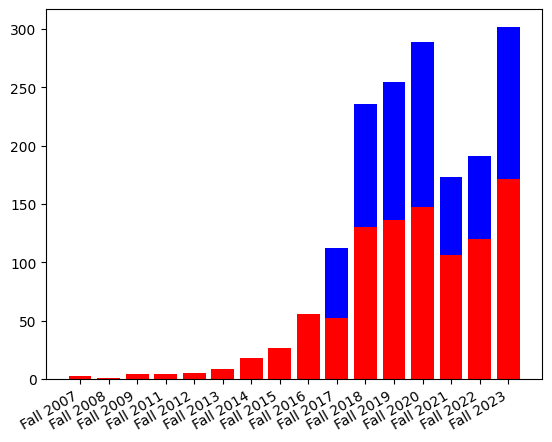

In [15]:
# we can visualize this with a stacked bar chart
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.bar(semesters, nonfresh_students, color='r')
plt.bar(semesters, fresh_students, bottom=nonfresh_students, color='b')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()